# OpenVINO™ Integration with TensorFlow Object Detection 

## OpenVINO version check:
You are currently using the latest development version of Intel® Distribution of OpenVINO™ Toolkit. 


## Prerequisites
This sample requires the following:
- All files are present and in the following directory structure:
    
    - **object_detection.ipynb** - This Jupyter* Notebook
    - **object_detection_sample_video_image.py** - Python* code for TensorFlow object detection
    - **object_detection_demo.py** - Python* code for OpenVINO object detection
    - **labels.txt** - Mapping of numerical labels to text strings
    - **../data/grace_hopper.jpg** - Test image
    - **convert_yolov4.sh** - Downloading the TensorFlow Yolo model

     

It is recommended that you have already read the following from [Get Started on the Intel® DevCloud for the Edge](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/overview.html):
- [Overview of the Intel® DevCloud for the Edge](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/overview.html)
- [Overview of the Intel® Distribution of OpenVINO™ toolkit](https://www.intel.com/content/www/us/en/developer/tools/devcloud/edge/learn/openvino.html)
- [Overview of the OpenVINO™ integration with TensorFlow](https://github.com/openvinotoolkit/openvino_tensorflow)

<br><div class=note><i><b>Note: </b>It is assumed that the server this sample is being run on is on the Intel® DevCloud for the Edge which has Jupyter* Notebook customizations and all the required libraries already installed.  If you download or copy to a new server, this sample may not run.</i></div>


## Introduction

This is a sample to showcase object detection in images/videos using YoloV4 TensorFlow Model using TensorFlow 2.x APIs. This is to showcase the performance and inference results using stock TensorFlow (Intel® CPUs), TensorFlow with OneDNN optimizations (Intel® CPUs), OpenVINO Integration with TensorFlow (Intel® CPUs and Accelerators) and OpenVINO Native(Intel® CPUs and Accelerators).
Accelerators refer to:
* Intel® integrated GPUs
* Intel® Neural Compute Stick with Movidius™ Vision Processing Units - referred as NCS2
* Intel® Vision Accelerator Design with 8 Intel Movidius™ MyriadX VPUs - referred as VAD-M or HDDL

At start-up the sample application reads command line arguments in to specify a target device which will be used during runtime to schedule inference on. Next, we load an TensorFlow model to be passed to TensorFlow, OpenVINO integration with TensorFlow that allow you to run inference on Intel hardware. 

A job is submitted to a device (Intel® Core CPU, Intel® HD Graphics GPU, Intel® Neural Compute Stick 2, Intel® VAD-M.). After the inference is completed, the output detections along with inference performance results are appropriately displayed within the Jupyter Notebook instance.

### Key concepts
This sample application includes an example for the following:
- Application demonstrates:
   - Stock TensorFlow with image/video input and object detection model on CPU
   - OpenVINO Integration with TensorFlow with image/video input and object detection model on CPU, iGPU, NCS2, VAD-M
   - Visualization of the images along with labels
   - Telemetry
   - Performance Comparison
- Intel® DevCloud for the Edge:
  - Submitting inference as jobs that are performed on different edge compute nodes (rather than on the development node hosting this Jupyter* notebook)
  - Monitoring job status
  - Viewing results and assessing performance for hardware on different compute nodes

#### Model Downloader
* This downloads the yolov4 tensorflow model

In [1]:
!source convert_yolov4.sh &>/dev/null

#### Import Python packages



In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
# Enable these variables for runtime inference optimizations
os.environ["OPENVINO_TF_CONVERT_VARIABLES_TO_CONSTANTS"] = "1"
os.environ[
    "TF_ENABLE_ONEDNN_OPTS"] = "1"
import argparse
import numpy as np
import tensorflow as tf
import openvino_tensorflow as ovtf
import time
import cv2
from PIL import Image as Img
import matplotlib.pyplot as plt
from qarpo.demoutils import *
from qarpo.model_visualizer_link import *

import sys
sys.path.append("../")
from common.utils import get_input_mode, get_colors, draw_boxes, get_anchors, rename_file
from common.pre_process import preprocess_image_yolov3 as preprocess_image
from common.post_process import yolo3_postprocess_np

2022-06-21 20:59:01.071884: I tensorflow/core/util/util.cc:159] Experimental oneDNN custom operations are on. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Helper Functions

Function to read labelmap file

In [3]:
def load_coco_names(file_name):
    names = {}
    assert os.path.exists(file_name), "path doesn't exist {0}".format(file_name)
    with open(file_name) as f:
        for coco_id, name in enumerate(f):
            names[coco_id] = name
    return names

Function to load labels

In [4]:

def load_labels(label_file):
    label = []
    proto_as_ascii_lines = tf.io.gfile.GFile(label_file).readlines()
    for l in proto_as_ascii_lines:
        label.append(l.rstrip())
    return label

Function to run inference on video file

In [5]:
def run_detect(model_file, label_file, input_file, input_height, input_width, backend_name, output_filename, rename=False, no_show=True):
    # Load model and process input image
    model = tf.saved_model.load(model_file)

    # Load the labels
    if label_file:
        classes = load_coco_names(label_file)
    anchors = get_anchors(anchor_file)

    cap = None
    video_writer = None
    images = []
    if label_file:
        labels = load_labels(label_file)
    colors = get_colors(labels)
    input_mode = get_input_mode(input_file)
    if input_mode == "video":
        cap = cv2.VideoCapture(input_file)
        video_writer = cv2.VideoWriter()
        output_resolution = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT )))
        output_filename = backend_name+"_"+output_filename
        video_writer.open(output_filename, cv2.VideoWriter_fourcc(*'avc1'), 20.0, output_resolution)
    elif input_mode == 'image':
        images = [input_file]
    elif input_mode == 'directory':
        if not os.path.isdir(input_file):
            raise AssertionError("Path doesn't exist {0}".format(input_file))
        images = [os.path.join(input_file, i) for i in os.listdir(input_file)]
        result_dir = os.path.join(input_file, '../detections')
        if not os.path.exists(result_dir):
            os.mkdir(result_dir)
    else:
        raise Exception(
            "Invalid input. Path to an image or video or directory of images. Use 0 for using camera as input."
        )
    images_len = len(images)
    image_id = -1
    # Run inference
    while True:
        image_id += 1
        if input_mode == 'video':
            if cap.isOpened():
                ret, frame = cap.read()
                if ret is True:
                    pass
                else:
                    break
            else:
                break
        if input_mode in ['image', 'directory']:
            if image_id < images_len:
                frame = cv2.imread(images[image_id])
            else:
                break
        img = frame
        image = Img.fromarray(img)
        
        if(backend_name == "VAD-M"):
            xlist = []
            for i in range(1, 9):
                x = tf.convert_to_tensor(preprocess_image(image, (input_height, input_width)))
                xlist.append(x)
            img_resized = np.stack(xlist)
            img_resized = tf.squeeze(img_resized,1)
        else:
            img_resized = tf.convert_to_tensor(preprocess_image(image, (input_height, input_width)))
            
        # Warmup
        if image_id == 0:
            detected_boxes = model(img_resized)

        # Run
        start = time.time()
        detected_boxes = model(img_resized)
        elapsed = time.time() - start
        fps = 1 / elapsed
        print('Inference time in ms: %.2f' % (elapsed * 1000))
        
        # post-processing
        image_shape = tuple((frame.shape[0], frame.shape[1]))
        out_boxes, out_classes, out_scores = yolo3_postprocess_np(
            detected_boxes,
            image_shape,
            anchors,
            len(labels), (input_height, input_width),
            max_boxes=10,
            confidence=conf_threshold,
            iou_threshold=iou_threshold,
            elim_grid_sense=True)
        # modified draw_boxes function to return an openCV formatted image
        img_bbox = draw_boxes(img, out_boxes, out_classes, out_scores, labels,
                              colors)
        # draw information overlay onto the frames
        cv2.putText(img_bbox, 'Inference Running on : {0}'.format(backend_name),
                    (30, 50), font, font_size, color, font_thickness)
        cv2.putText(
            img_bbox, 'FPS : {0} | Inference Time : {1}ms'.format(
                int(fps), round((elapsed * 1000), 2)), (30, 80), font,
            font_size, color, font_thickness)
        if input_mode in 'directory':
            out_file = "detections_{0}.jpg".format(image_id)
            out_file = os.path.join(result_dir, out_file)
            cv2.imwrite(out_file, img_bbox)
        if input_mode in 'image':
            cv2.imwrite("detections.jpg", img_bbox)
            print("Output image is saved in detections.jpg")
        if not no_show:
            cv2.imshow("detections", img_bbox)
            if cv2.waitKey(1) & 0XFF == ord('q'):
                break
        if rename:
            rename_file(images[image_id], out_classes, labels)
        if input_mode == 'video':
            video_writer.write(img_bbox)
    if input_mode in 'directory':
        print("Output images is saved in {0}".format(
            os.path.abspath(result_dir)))
    

    if cap:
        cap.release()
    if video_writer:
        video_writer.release()
    cv2.destroyAllWindows()


#### Run inference on OpenVINO Integration with TensorFlow
* This workload can be modified to enable/disable Openvino Integration with Tensorflow by setting the "flag_enable" argument
    * "native" for Stock TensorFlow
    * "openvino" for enabling Openvino Integration with Tensorflow
* Currently this workload works for both video and image type.
    * Set the argument "input_type" as image/video
    * Change the "input_file" path to actual file
    * Change the output filename to image/video extensions
* Backend can be changed to "CPU, GPU, GPU_FP16, MYRIAD or VAD-M"

In [6]:
flag_enable = "openvino" # please edit for native Tensorflow
input_file = "../data/images/grace_hopper.jpg"
model_file = "../data/yolo_v4"
label_file = "../data/coco.names"
anchor_file = "../data/yolov4_anchors.txt"
input_height = 160
input_width = 160
input_mean = 0
input_std = 255
backend_name = "CPU"
output_file = "output_detections.jpg"

In [7]:
if __name__ == "__main__":
    
    output_dir = "."
    conf_threshold = 0.6
    iou_threshold = 0.5
 
    # overlay parameters
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = .6
    color = (0, 0, 0)
    font_thickness = 2

   
    # Print list of available backends
    if(flag_enable == "native"):
        print('StockTensorflow')
        ovtf.disable()
    elif(flag_enable == "openvino"):
        print('Openvino Integration With Tensorflow')
        print('Available Backends:')
        backends_list = ovtf.list_backends()
        for backend in backends_list:
            print(backend)
        os.environ['TF_ENABLE_ONEDNN_OPTS']='1'
        ovtf.set_backend(backend_name)
    else:
        raise AssertionError("flag_enable string not supported")
       
    run_detect(model_file, label_file,input_file,input_height,input_width, backend_name, output_file)   

Openvino Integration With Tensorflow
Available Backends:
CPU
VAD-M


2022-06-21 20:59:17.075523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-06-21 20:59:26.462418: OVTF Summary -> 382 out of 1470 nodes in the graph (25%) are now running with OpenVINO™ backend
Inference time in ms: 91.77
person 0.97
tie 0.66
Output image is saved in detections.jpg


#### Openvino Integration with Tensorflow Model Support
* TensorFlow with OpenVINO Integration with TensorFlow supports models listed in <a href="https://github.com/openvinotoolkit/openvino_tensorflow/blob/master/docs/MODELS.md">here</a>
* Some models might require a different preprocess. Please change preprocessing methods accordingly



## Run Openvino Integration with Tensorflow Inference

All the code up to this point has been run within the Jupyter Notebook instance running on a development node based on an Intel® Xeon® Scalable Processor, where the Notebook is allocated a single core. We will now run the workload on several DevCloud's edge compute nodes. We will send work to the edge compute nodes by submitting jobs into a queue. For each job, we will specify the type of the edge compute node that must be allocated for the job.

#### Check available edge compute nodes
The following command can be used to check the available edge compute nodes that can be used and certain configurations. 

The job file will be executed directly on the edge compute node. Use the below command to find the edge nodes.

In [8]:
!pbsnodes | grep compnode | awk '{print $3}' | sort | uniq -c

     15 idc001skl,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb
     14 idc002mx8,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb,myriadx-8-vpu
     11 idc004nc2,compnode,openvino-latest,intel-core,i5-6500te,intel-hd-530,ram8gb,myriadx-1-vpu
      5 idc006kbl,compnode,openvino-latest,intel-core,i5-7500t,intel-hd-630,ram8gb
      5 idc007xv5,compnode,openvino-latest,intel-xeon,e3-1268l-v5,intel-hd-p530,ram32gb
      5 idc008u2g,compnode,openvino-latest,intel-atom,e3950,intel-hd-505,ram4gb,myriadx-1-vpu
      1 idc009jkl,compnode,openvino-latest,intel-core,i5-7500,intel-hd-630,ram8gb
      1 idc010jal,compnode,openvino-latest,intel-celeron,j3355,intel-hd-500,ram4gb
      1 idc011ark2250s,compnode,openvino-latest,intel-core,i5-6442eq,intel-hd-530,ram8gb,myriadx-3-vpu
      1 idc012ark1220l,compnode,openvino-latest,intel-atom,e3940,intel-hd-500,ram4gb,myriadx-2-vpu
      1 idc013ds580,compnode,openvino-latest,intel-atom,e3950,intel-hd-505,ram2gb
      

#### Monitor job status
Before going to the job submission step, we want to first talk about how to check the status of the jobs that have been submitted.  The `qstat` command can be used for this purpose.  The custom Jupyter* Notebook widget `liveQstat()` is provided to display the output of `qstat` with live updates.  

Run the following cell to display the current job status with periodic updates.  

In [9]:
from qarpo.demoutils import *
liveQstat()

Output(layout=Layout(border='1px solid gray', height='200px', overflow_y='auto', width='100%'))

Button(description='Stop', style=ButtonStyle())

You should see the jobs that you have submitted (referenced by the `JobID` that gets displayed right after you submit the jobs in the previous step).
There should also be an extra job in the queue named `jupyterhub-singleuser`: this job is your current Jupyter* Notebook session which is always running.

The `S` column shows the current status of each job: 
- If the status is `Q`, then the job is queued and waiting for available resources
- If ste status is `R`, then the job is running
- If the job is no longer listed, then the job has completed

<br><div class=note><i><b>
Note: The amount of time spent in the queue depends on the number of users accessing the requested compute nodes. Once the jobs for this sample application begin to run, they should take from 1 to 5 minutes each to complete.
</b></i></div>

#### Create the job file
We will run inference on several different edge compute nodes present in the Intel® DevCloud for the Edge. We will send work to the edge compute nodes by submitting the corresponding non-interactive jobs into a queue. For each job, we will specify the type of the edge compute server that must be allocated for the job.

The job file is a [Bash](https://www.gnu.org/software/bash/) script that serves as a wrapper around the Python* executable of our application that will be executed directly on the edge compute node.  One purpose of the job file is to simplify running an application on different compute nodes by accepting a few arguments and then performing accordingly any necessary steps before and after running the application executable.  

For this sample, the job file we will be using is already written for you and appears in the next cell.  The job file will be submitted as if it were run from the command line using the following format

```bash
run_tensorflow_*.sh
```

Based on the input arguments, the job file will do the following:
- Change to the working directory `PBS_O_WORKDIR` where this Jupyter* Notebook and other files appear on the compute node
- Create the <*output_directory*>
- Run the application Python* executable with the appropriate command line arguments

Run the following cell to create the job file.  The [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) line at the top will write the cell contents to the specified job file `run_tensorflow.sh`.

For Performance comparision, we use only video file as input for both Tensorflow and Openvino applications.


Below script is used to schedule inference on edge node with native TensorFlow

In [10]:
%%writefile run_native_tensorflow.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR
if [ ! -d "./results/" ];then
   mkdir -p ./results
fi
DEVICE=$1
source /data/venv/tf_ov/bin/activate
source /opt/intel/openvino_2022/setupvars.sh

pip install matplotlib

# cmd to run the TensorFlow classification code
python3 object_detection_sample_video_image.py --no_show --model "../data/yolo_v4"\
                       --labels "../data/coco.names" \
                       --input "../data/images/people-detection.mp4"\
                       --backend $DEVICE \
                       -f "native"

Writing run_native_tensorflow.sh


Below script is used to run inference on edge nodes with OpenVINO Add-on

In [11]:
%%writefile run_openvino_tensorflow.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR
if [ ! -d "./results/" ];then
   mkdir -p ./results
fi

DEVICE=$1
source /data/venv/tf_ov/bin/activate
source /opt/intel/openvino_2022/setupvars.sh


# cmd to run the OpenVINO Tensorflow Add-on classification code
python3 object_detection_sample_video_image.py --no_show --model "../data/yolo_v4"\
                       --input "../data/images/people-detection.mp4"\
                       --labels "../data/coco.names" \
                       --backend $DEVICE \
                       -f "openvino"
                       

Writing run_openvino_tensorflow.sh


To understand the security measures that we take please review our [security best practices](https://devcloud.intel.com/edge/resource_docs/security_best_practices/).

### Intel® CPU with stock TensorFlow
In the cell below, we submit a job to an edge node with an [Intel® Xeon® Gold 6258R Processor](https://ark.intel.com/content/www/us/en/ark/products/199350/intel-xeon-gold-6258r-processor-38-5m-cache-2-70-ghz.html). The inference workload will run on the CPU.
  


In [12]:
#Submit job to the queue
job_id_core_stock = !qsub run_native_tensorflow.sh -l nodes=1:idc017 -F "CPU" -N native_tensorflow_cpu
id_core_stock = job_id_core_stock[0].split('.')[0]
print("Job ID: ", id_core_stock) 

Job ID:  469163


### Intel® CPU with OpenVINO™ Integration with TensorFlow
In the cell below, we submit a job to an edge node with an [Intel® Xeon® Gold 6258R Processor](https://ark.intel.com/content/www/us/en/ark/products/199350/intel-xeon-gold-6258r-processor-38-5m-cache-2-70-ghz.html). The inference workload will run on the CPU.

In [32]:
#Submit job to the queue
job_id_core = !qsub run_openvino_tensorflow.sh -l nodes=1:idc017 -F "CPU" -N openvino_tensorflow_cpu
id_core = job_id_core[0].split('.')[0]
print("Job ID: ", id_core) 

Job ID:  469179


### Intel® GPU with OpenVINO™ Integration with TensorFlow 
In the cell below, we submit a job to an edge node with an [Intel® Core i7-8665](https://ark.intel.com/content/www/us/en/ark/products/193563/intel-core-i7-8665u-processor-8m-cache-up-to-4-80-ghz.html). The inference workload will run on the 
Intel® UHD Graphics 620 GPU integrated with the CPU.

In [14]:
#Submit job to the queue
job_id_gpu = !qsub run_openvino_tensorflow.sh -l nodes=1:idc014 -F "GPU" -N openvino_tensorflow_gpu 
id_gpu = job_id_gpu[0].split('.')[0]
print("Job ID: ", id_gpu) 

Job ID:  469165


### Intel® Neural Compute Stick 2 with OpenVINO™ Integration with TensorFlow  
In the cell below, we submit a job to an edge node with an [Intel Core i5-6500te](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz.html) CPU. The inference workload will run on an [Intel® Neural Compute Stick 2](https://software.intel.com/en-us/neural-compute-stick) installed in this node.

In [15]:
#Submit job to the queue
job_id_ncs2 = !qsub run_openvino_tensorflow.sh -l nodes=1:idc004nc2 -F "MYRIAD" -N openvino_tensorflow_ncs2
id_ncs2 = job_id_ncs2[0].split('.')[0]
print("Job ID: ", id_ncs2)

Job ID:  469166


### IEI Mustang-V100-MX8 ( Intel® Movidius™ Myriad™ X Vision Processing Unit (VPU))
In the cell below, we submit a job to an edge node with an [Intel Core i5-6500te CPU](https://ark.intel.com/products/88186/Intel-Core-i5-6500TE-Processor-6M-Cache-up-to-3-30-GHz.html). The inference workload will run on an [Intel® Vision Accelerator Design with Intel® Movidius™ VPUs](https://software.intel.com/openvino-toolkit/hardware#VPU) accelerator installed in this node that has eight VPUs.

Below script runs inference for a batch of 8 images on 8 VPUs simultaneously

In [21]:
%%writefile run_openvino_tensorflow_hddl.sh

# The default path for the job is your home directory, so we change directory to where the files are.
cd $PBS_O_WORKDIR
if [ ! -d "./results/" ];then
   mkdir -p ./results
fi
DEVICE=$1
source /data/venv/tf_ov/bin/activate
source /opt/intel/openvino_2022/setupvars.sh



export OPENVINO_TF_ENABLE_BATCHING=1
# cmd to run the OpenVINO Tensorflow Add-on classification code
python3 object_detection_sample_video_image.py --no_show --model "../data/yolo_v4"\
                       --input "../data/images/people-detection.mp4"\
                       --labels "../data/coco.names" \
                       --backend $DEVICE \
                       -f "openvino"
                       

Overwriting run_openvino_tensorflow_hddl.sh


In [17]:
#Submit job to the queue
job_id_hddlr_batch = !qsub run_openvino_tensorflow_hddl.sh -l nodes=1:idc002mx8 -F "VAD-M" -N openvino_tensorflow_hddl_batch
id_hddlr_batch = job_id_hddlr_batch[0].split('.')[0]
print("Job ID: ", id_hddlr_batch) 

Job ID:  469167


## Performance Comparison

Please execute this cell only after all the cells/jobs have successfully finished execution


The inference time is written to files in the 'results' folder and plotted as below

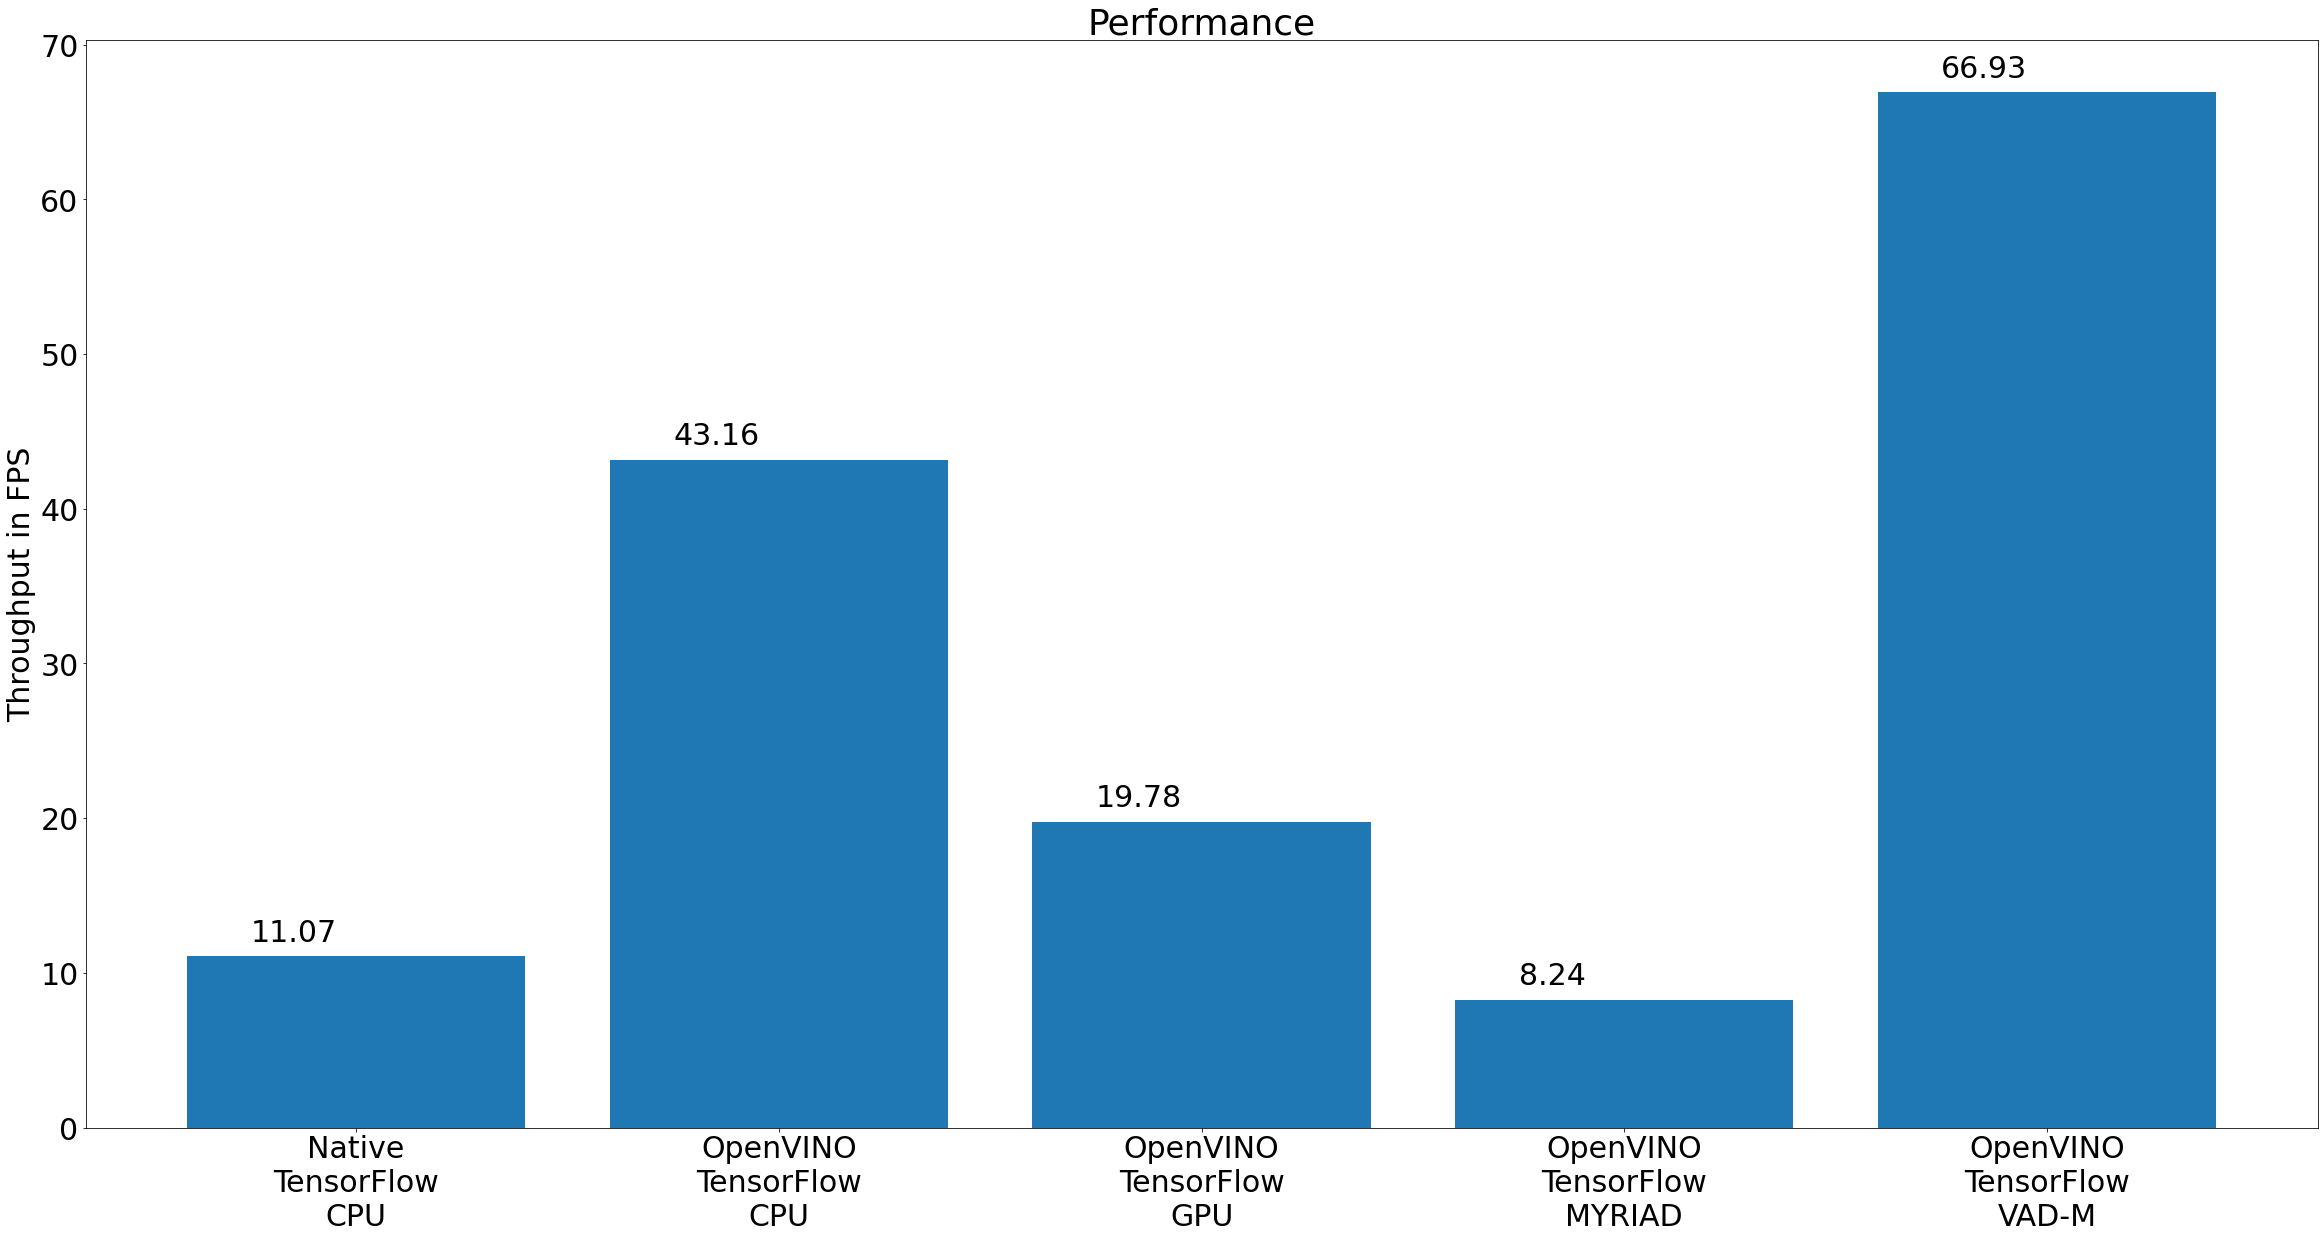

In [34]:
arch_list = ['Native\nTensorFlow\nCPU', 'OpenVINO\nTensorFlow\nCPU',
             'OpenVINO\nTensorFlow\nGPU', 'OpenVINO\nTensorFlow\nMYRIAD', 
             'OpenVINO\nTensorFlow\nVAD-M']

file_list = ['native_tensorflow_CPU.txt', 'openvino_tensorflow_CPU.txt',
             'openvino_tensorflow_GPU.txt', 'openvino_tensorflow_MYRIAD.txt', 
             'openvino_tensorflow_VAD-M.txt']

values = []

for file in file_list:
    f = open('results/' + file)
    v = f.read()
    values.append(float(v))

plt.figure(figsize=(40, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
plt.ylabel('Throughput in FPS')
plt.bar(arch_list, values)
for index, value in enumerate(values):
    plt.text(index - 0.25, 1 + value, str(round(value, 2)), fontsize=30)

plt.title('Performance')
plt.show()

## Next steps
- [More Jupyter* Notebook Samples](https://devcloud.intel.com/edge/advanced/sample_applications/) - additional sample applications 
- [Jupyter* Notebook Tutorials](https://devcloud.intel.com/edge/get_started/tutorials) - sample application Jupyter* Notebook tutorials
- [Intel® Distribution of OpenVINO™ toolkit Main Page](https://software.intel.com/openvino-toolkit) - learn more about the tools and use of the Intel® Distribution of OpenVINO™ toolkit for implementing inference on the edge

## About this notebook

For technical support, please see the [Intel® DevCloud Forums](https://software.intel.com/en-us/forums/intel-devcloud-for-edge)


<p style=background-color:#0071C5;color:white;padding:0.5em;display:table-cell;width:100pc;vertical-align:middle>
<img style=float:right src="https://devcloud.intel.com/edge/static/images/svg/IDZ_logo.svg" alt="Intel DevCloud logo" width="150px"/>
<a style=color:white>Intel® DevCloud for the Edge</a><br>   
<a style=color:white href="#top">Top of Page</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Intel-DevCloud-for-the-Edge-Usage-Agreement.pdf">Usage Agreement (Intel)</a> | 
<a style=color:white href="https://devcloud.intel.com/edge/static/docs/terms/Colfax_Cloud_Service_Terms_v1.3.pdf">Service Terms (Colfax)</a>
</p>
